# Train model

Train and fine-tune a headless MobileNet V3 on a target image dataset directory

## Config

In [1]:
import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import RandomRotation, RandomFlip, RandomZoom, Dropout, Dense, Input
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.losses import CategoricalCrossentropy
import matplotlib.pyplot as plt
import os
from pathlib import Path
import logging
import pandas as pd
import numpy as np
import sqlalchemy as sqa
from typing import Callable
from collections import Counter
from scipy.stats import entropy
from matplotlib.ticker import StrMethodFormatter
from sklearn.metrics import roc_curve, auc
import json

logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.propagate = False

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['font.size'] = 12

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)


In [2]:
# PARAMETERS
# Model Parameters
image_size = (224, 224)
batch_size = 16
dropout_rate = 0.2
shuffle_buffer = 50

epochs = {
    'top_layer': 500,
    'fine_tuning': 500
}

learning_rates = {
    'top_layer': 0.0001,
    'fine_tuning': 0.00001
}

fine_tune_unfreeze_frac = 0.3

class_weight_defaults = {
    'positive': 1,
    'negative': 1,
    'negative_similar_plant': 0.9,
    'negative_random_picture': 0.4,
    'negative_general_plant': 0.8,
}

model_output_path = '../models/pipeline_v1/MNv3-xfer_multiclass_v1'
model_labels_path = '../models/pipeline_v1/class_labels_multiclass.json'


# Data parameters
db_container = "metadata_db"
db_user = "pguser"
db_password = "pgpassword"
db_port = 5432
db_database = "metadata"
db_prefix = "postgresql"

class_weights = {} # TODO use class weights

metadata_tbl = "base_images"
datasets_tbl = "datasets"
dataset_img_tbl = "dataset_images"

dataset_name = "all_v1_multiclass"
# dataset_name = "all_v1_binary"
# dataset_name = "test_multi_example"
# dataset_name = "test_bin_example"

# Output parameters
dataset_img_path = f"../datasets/pipeline_v1/{dataset_name}_pipeline/"

In [3]:
db_con_str = f"{db_prefix}://{db_user}:{db_password}@{db_container}:{db_port}/{db_database}"
db_engine = sqa.create_engine(db_con_str)

input_shape = (*image_size, 3)

In [4]:
with db_engine.connect() as con:
    df_dataset = pd.read_sql_query(f"""
                                   SELECT * FROM {datasets_tbl}
                                   WHERE name = '{dataset_name}'
                                   """, con, index_col='name')
    df_imgs = pd.read_sql_query(f"""
                                SELECT * FROM {dataset_img_tbl}
                                LEFT JOIN {metadata_tbl} ON {dataset_img_tbl}.image_name = {metadata_tbl}.image_name
                                WHERE dataset_name = '{dataset_name}'
                                """
                                , con, index_col='image_name')
    
ds_config = df_dataset.loc[dataset_name].to_dict()
ds_config['has_test'] = ds_config['test_frac'] > 0
ds_config['has_val'] = ds_config['validation_frac'] > 0
ds_config

{'target_dir': '/home/code/datasets/pipeline_v1/all_v1_multiclass',
 'description': 'All images in v1 dataset with multiclass labels',
 'validation_frac': 0.2,
 'test_frac': 0.0,
 'label_method': 'MULTI',
 'has_test': False,
 'has_val': True}

In [5]:
train_dir = os.path.join(ds_config['target_dir'], 'train')
test_dir = os.path.join(ds_config['target_dir'], 'test')
val_dir = os.path.join(ds_config['target_dir'], 'validation')

## Datasets

In [6]:
def _get_image_name(img_path: str):
    """
    Convert image path to appropriate label
    """
    return(Path(img_path).name.replace("'", ""))

def label_tf_image_dataset(img_ds: tf.data.Dataset,
                           label_func: Callable[[str], str] = _get_image_name,
                           batch_size: int = batch_size) -> tf.data.Dataset:
    """
    Zips an image dataset (images, class_labels) with their image file names
    Works on unshuffled datasets & batch sizes must match
    Returns a dataset like ((images, class_labels), image_names)
    """
    img_labels = [label_func(img_path) for img_path in img_ds.file_paths]
    return tf.data.Dataset.zip((
        img_ds,
        tf.data.Dataset.from_tensor_slices(img_labels).batch(batch_size)
    ))
AUTOTUNE = tf.data.AUTOTUNE


# Make datasets
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=batch_size,
                                                            image_size=image_size,
                                                            label_mode='categorical')
class_names = train_dataset.class_names
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

val_dataset = None
if ds_config['has_val']:
    val_dataset = tf.keras.utils.image_dataset_from_directory(val_dir,
                                                              batch_size=batch_size,
                                                              shuffle=True,
                                                              image_size=image_size,
                                                              label_mode='categorical')
    val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)

test_dataset = None
if ds_config['has_test']:
    test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                              batch_size=batch_size,
                                                              shuffle=True,
                                                              image_size=image_size,
                                                              label_mode='categorical')
    test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Found 8146 files belonging to 4 classes.
Found 2037 files belonging to 4 classes.


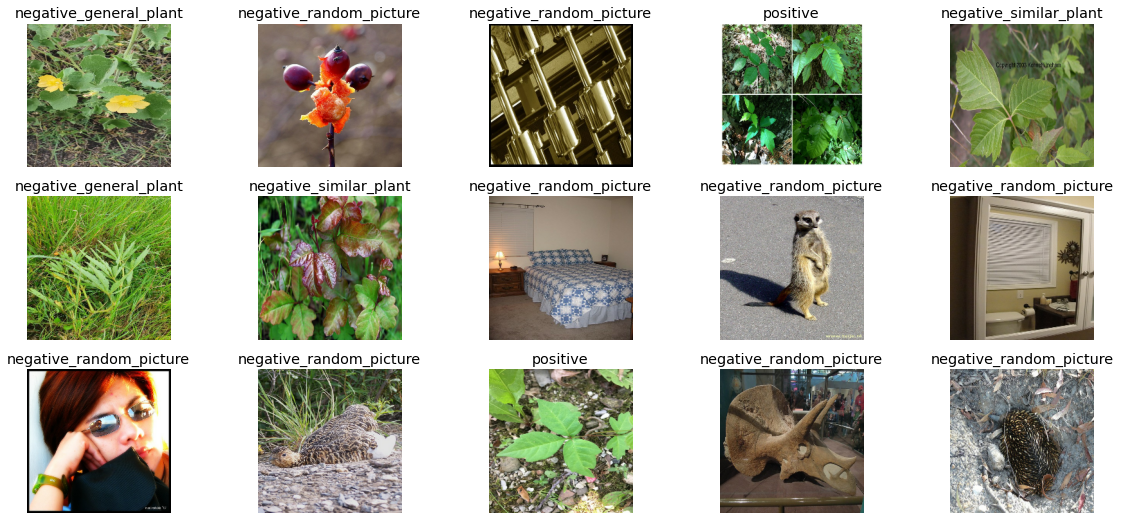

In [7]:
# TODO: fix so this takes from many class label?
n_classes = len(class_names)
y_ims = 3
x_ims = 5

plt.figure(figsize=(x_ims*4, y_ims*3))
for images, labels in train_dataset.take(1):
  for i in range(y_ims*x_ims):
    ax = plt.subplot(y_ims, x_ims, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i].numpy().argmax()])
    plt.axis("off")

In [8]:
class_weights = {
    i: class_weight_defaults[class_name]
    for i, class_name in enumerate(class_names)
}
print(class_weights)

{0: 0.8, 1: 0.4, 2: 0.9, 3: 1}


## Processing layers

In [9]:

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)


### Image augmentation

In [10]:
image_aug = Sequential([
    RandomFlip('horizontal'),
    RandomRotation(0.2),
    RandomZoom(0.1)
])

### Mobilenet

In [11]:
mobilenet_large = MobileNetV3Large(input_shape=input_shape,
                                   include_top=False,
                                   weights='imagenet',
                                   pooling='avg',
                                   include_preprocessing=True,
                                   dropout_rate=dropout_rate)

mobilenet_large.trainable = False
mobilenet_large.summary()

Model: "MobilenetV3large"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 112, 112, 16) 432         rescaling[0][0]                  
__________________________________________________________________________________________________
Conv/BatchNorm (BatchNormalizat (None, 112, 112, 16) 64          Conv[0][0]                       
___________________________________________________________________________________

In [12]:
def build_model(mobilenet):
    inputs = Input(shape=input_shape)
    x = image_aug(inputs)
    x = mobilenet(x, training=False)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(n_classes, activation='softmax')(x)
    
    return(Model(inputs, outputs))
    

In [13]:
model = build_model(mobilenet_large)

In [14]:
model.compile(optimizer=Adam(learning_rate=learning_rates['top_layer']),
              loss=CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [15]:
early_stopping = EarlyStopping(patience=12, restore_best_weights=False)
reduce_lr = ReduceLROnPlateau(patience=4, factor=1./3.)
callbacks = [early_stopping, reduce_lr]

In [16]:
kwargs = {
    'epochs': epochs['top_layer'],
    'callbacks': callbacks
}
if ds_config['has_val']:
    kwargs['validation_data'] = val_dataset

history = model.fit(train_dataset, class_weight=class_weights, **kwargs)
print("MODEL COMPLETE")

Epoch 1/500
510/510 [==============================] - 34s 52ms/step - loss: 0.4061 - accuracy: 0.8010 - val_loss: 0.3667 - val_accuracy: 0.8827
Epoch 2/500
510/510 [==============================] - 26s 51ms/step - loss: 0.2322 - accuracy: 0.8974 - val_loss: 0.2912 - val_accuracy: 0.9018
Epoch 3/500
510/510 [==============================] - 31s 61ms/step - loss: 0.1813 - accuracy: 0.9233 - val_loss: 0.2446 - val_accuracy: 0.9165
Epoch 4/500
510/510 [==============================] - 27s 53ms/step - loss: 0.1594 - accuracy: 0.9330 - val_loss: 0.2184 - val_accuracy: 0.9278
Epoch 5/500
510/510 [==============================] - 26s 51ms/step - loss: 0.1408 - accuracy: 0.9433 - val_loss: 0.2051 - val_accuracy: 0.9273
Epoch 6/500
510/510 [==============================] - 27s 54ms/step - loss: 0.1262 - accuracy: 0.9502 - val_loss: 0.1920 - val_accuracy: 0.9327
Epoch 7/500
510/510 [==============================] - 28s 55ms/step - loss: 0.1136 - accuracy: 0.9559 - val_loss: 0.2402 - val_ac

## Fine-tune models

In [17]:
unfreeze = int(len(mobilenet_large.layers) * fine_tune_unfreeze_frac)

print(f"Mobilenet-large: Unfreezing {unfreeze} of {len(mobilenet_large.layers)} layers")
mobilenet_large.trainable = True
for layer in mobilenet_large.layers[:-unfreeze]:
    layer.trainable = False

Mobilenet-large: Unfreezing 81 of 270 layers


In [18]:
mobilenet_large.summary()

Model: "MobilenetV3large"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 112, 112, 16) 432         rescaling[0][0]                  
__________________________________________________________________________________________________
Conv/BatchNorm (BatchNormalizat (None, 112, 112, 16) 64          Conv[0][0]                       
___________________________________________________________________________________

In [19]:
model.compile(optimizer=RMSprop(learning_rate=learning_rates['fine_tuning']),
              loss=CategoricalCrossentropy(),
              metrics=['accuracy'])

In [20]:
print(len(history.epoch))

29


In [21]:
base_epochs = len(history.epoch)
history_FT = model.fit(train_dataset,
                       validation_data=val_dataset,
                       epochs=epochs['fine_tuning'] + base_epochs,
                       initial_epoch=history.epoch[-1],
                       callbacks=callbacks,
                       class_weight=class_weights)

Epoch 29/529
510/510 [==============================] - 45s 77ms/step - loss: 0.0532 - accuracy: 0.9821 - val_loss: 0.1766 - val_accuracy: 0.9406
Epoch 30/529
510/510 [==============================] - 37s 73ms/step - loss: 0.0452 - accuracy: 0.9858 - val_loss: 0.1961 - val_accuracy: 0.9401
Epoch 31/529
510/510 [==============================] - 39s 76ms/step - loss: 0.0466 - accuracy: 0.9854 - val_loss: 0.1675 - val_accuracy: 0.9440
Epoch 32/529
510/510 [==============================] - 38s 74ms/step - loss: 0.0460 - accuracy: 0.9842 - val_loss: 0.1542 - val_accuracy: 0.9470
Epoch 33/529
510/510 [==============================] - 41s 80ms/step - loss: 0.0431 - accuracy: 0.9870 - val_loss: 0.1766 - val_accuracy: 0.9470
Epoch 34/529
510/510 [==============================] - 49s 96ms/step - loss: 0.0391 - accuracy: 0.9882 - val_loss: 0.1492 - val_accuracy: 0.9529
Epoch 35/529
510/510 [==============================] - 48s 94ms/step - loss: 0.0410 - accuracy: 0.9876 - val_loss: 0.1825 -

## Analyze history

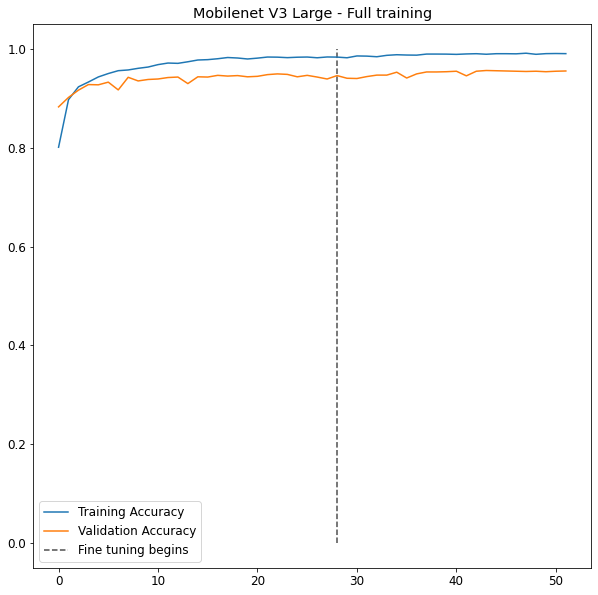

In [22]:
plt.figure(figsize=(10,10))

total_history = {}
for metric in ['accuracy', 'val_accuracy']:
    total_history[metric] = history.history[metric] + history_FT.history[metric]

ax = plt.subplot(1,1,1)
plt.plot(total_history['accuracy'], label='Training Accuracy')
plt.plot(total_history['val_accuracy'], label='Validation Accuracy')
y_min, y_max = (0, 1)
plt.vlines(base_epochs-1, ymin=y_min, ymax=y_max, label='Fine tuning begins', linestyles='--', colors=[0.3]*3)
plt.title("Mobilenet V3 Large - Full training")
plt.legend()


plt.show()

## Analyze results

In [23]:
POSITIVE = 'positive'
NEGATIVE = 'negative'
POSITIVE_IND = class_names.index(POSITIVE)

### Build results dataset

In [24]:
result_records = []
ds_splits = {'train': train_dataset, 'val': val_dataset, 'test': test_dataset}
class_name_counts = Counter()

for split, dataset in ds_splits.items():
    if dataset is not None:
        for imgs, class_labels in dataset:
            probs = model.predict(imgs)
            class_values = class_labels.numpy().argmax(axis=1)
            for prob, class_val in zip(probs, class_values):
                pred = prob.argmax()
                class_name = class_names[class_val]
                class_name_counts[class_name] += 1
                img_name = class_name + '_' + str(class_name_counts[class_name])   # Count image within class to name it
                target_path = Path(Path(dataset_img_path).absolute().resolve(), img_name + '.jpg')

                record = {'ds_image_name': img_name,
                          'split': split,
                          'class_value': class_val,
                          'class_name': class_names[class_val],
                          'pred_val': pred,
                          'pred_probs': prob,
                          'pred_class': class_names[pred],
                          'is_positive': class_val == POSITIVE_IND,
                          'pred_positive': pred == POSITIVE_IND,
                          'binary_pred': POSITIVE if pred == POSITIVE_IND else NEGATIVE,
                          'binary_class': POSITIVE if class_val == POSITIVE_IND else NEGATIVE,
                          'positive_prob': prob[POSITIVE_IND],
                          'target_path': target_path}
                result_records.append(record)
df_res = pd.DataFrame(result_records).set_index('ds_image_name')
df_res['pred_entropy'] = df_res['pred_probs'].map(entropy)
del(result_records)
df_res.head()

,split,class_value,class_name,pred_val,pred_probs,pred_class,is_positive,pred_positive,binary_pred,binary_class,positive_prob,target_path,pred_entropy
ds_image_name,,,,,,,,,,,,,
negative_random_picture_1,train,1,negative_random_picture,1,"[5.0242656e-05, 0.9999497, 7.4367534e-08, 2.18...",negative_random_picture,False,False,negative,negative,2.180189e-09,/home/code/datasets/pipeline_v1/all_v1_multicl...,0.000549
negative_random_picture_2,train,1,negative_random_picture,1,"[4.945306e-07, 0.99999654, 8.1865565e-08, 2.94...",negative_random_picture,False,False,negative,negative,2.944969e-06,/home/code/datasets/pipeline_v1/all_v1_multicl...,0.000049
negative_general_plant_1,train,0,negative_general_plant,0,"[0.8233458, 2.5957502e-07, 0.17665343, 5.50477...",negative_general_plant,False,False,negative,negative,5.504771e-07,/home/code/datasets/pipeline_v1/all_v1_multicl...,0.466293
negative_general_plant_2,train,0,negative_general_plant,0,"[0.99280375, 8.7238493e-07, 0.0071927207, 2.72...",negative_general_plant,False,False,negative,negative,2.721773e-06,/home/code/datasets/pipeline_v1/all_v1_multicl...,0.042711
positive_1,train,3,positive,3,"[0.00021922795, 1.339973e-06, 0.3541676, 0.645...",positive,True,True,positive,positive,6.456118e-01,/home/code/datasets/pipeline_v1/all_v1_multicl...,0.651978


In [25]:
conf_matrix = (
    df_res.groupby(['split', 'class_name', 'pred_class'])['class_value']
        .count()
        .reset_index()
        .rename({'class_value': 'counts'}, axis=1)
        .pivot(index=['split', 'class_name'], columns='pred_class', values='counts')
        .fillna(0)
        .astype('int')
)

conf_matrix

pred_class                     negative_general_plant  \
split class_name                                        
train negative_general_plant                     1874   
      negative_random_picture                       7   
      negative_similar_plant                        7   
      positive                                      0   
val   negative_general_plant                      429   
      negative_random_picture                       4   
      negative_similar_plant                        4   
      positive                                      0   

pred_class                     negative_random_picture  \
split class_name                                         
train negative_general_plant                         7   
      negative_random_picture                     3128   
      negative_similar_plant                         0   
      positive                                       0   
val   negative_general_plant                        11   
      negative_random_picture                      774   
      negative_similar_plant                         0   
      positive                                       0   

pred_class                     negative_similar_plant  positive  
split class_name                                                 
train negative_general_plant                       75         3  
      negative_random_picture                       3         0  
      negative_similar_plant                     1469        54  
      positive                                     28      1491  
val   negative_general_plant                       43         7  
      negative_random_picture                       6         1  
      negative_similar_plant                      369         9  
      positive                                      6       374

In [26]:
split_sums = conf_matrix.groupby('split').sum().sum(axis=1)
conf_mat_frac = conf_matrix.apply(
    lambda col: pd.DataFrame(col).apply(
        lambda row: row.iloc[0] / split_sums[row.name[0]],
    axis=1), 
axis=0)
conf_mat_frac

pred_class                     negative_general_plant  \
split class_name                                        
train negative_general_plant                 0.230052   
      negative_random_picture                0.000859   
      negative_similar_plant                 0.000859   
      positive                               0.000000   
val   negative_general_plant                 0.210604   
      negative_random_picture                0.001964   
      negative_similar_plant                 0.001964   
      positive                               0.000000   

pred_class                     negative_random_picture  \
split class_name                                         
train negative_general_plant                  0.000859   
      negative_random_picture                 0.383992   
      negative_similar_plant                  0.000000   
      positive                                0.000000   
val   negative_general_plant                  0.005400   
      negative_random_picture                 0.379971   
      negative_similar_plant                  0.000000   
      positive                                0.000000   

pred_class                     negative_similar_plant  positive  
split class_name                                                 
train negative_general_plant                 0.009207  0.000368  
      negative_random_picture                0.000368  0.000000  
      negative_similar_plant                 0.180334  0.006629  
      positive                               0.003437  0.183035  
val   negative_general_plant                 0.021109  0.003436  
      negative_random_picture                0.002946  0.000491  
      negative_similar_plant                 0.181149  0.004418  
      positive                               0.002946  0.183603

In [27]:
## FROM MATPLOTLIB DOCS: https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html

def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", include_cbar=True, **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    if include_cbar:
        cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
        cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_xticklabels(col_labels)
    ax.set_yticks(np.arange(data.shape[0]))
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for spine in ['left', 'right', 'top', 'bottom']:
        ax.spines[spine].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            # kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

<class 'matplotlib.axes._subplots.AxesSubplot'>


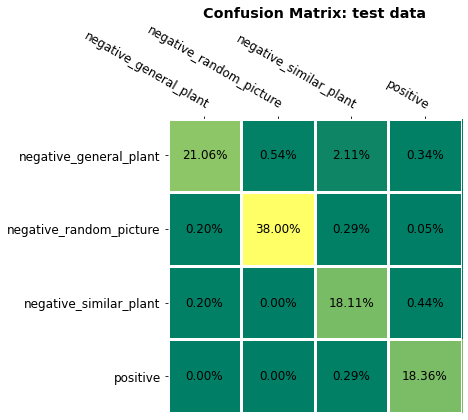

In [28]:
fig, ax = plt.subplots(figsize=(10,6))
cm_plot = conf_mat_frac.loc['val']
print(type(ax))
im = heatmap(cm_plot, cm_plot.index, cm_plot.columns, ax=ax, include_cbar=False, cmap="summer")
texts = annotate_heatmap(im, valfmt="{x:.2%}")
ax.set_title(f"Confusion Matrix: {split} data", fontweight='bold')
fig.tight_layout()
plt.show()

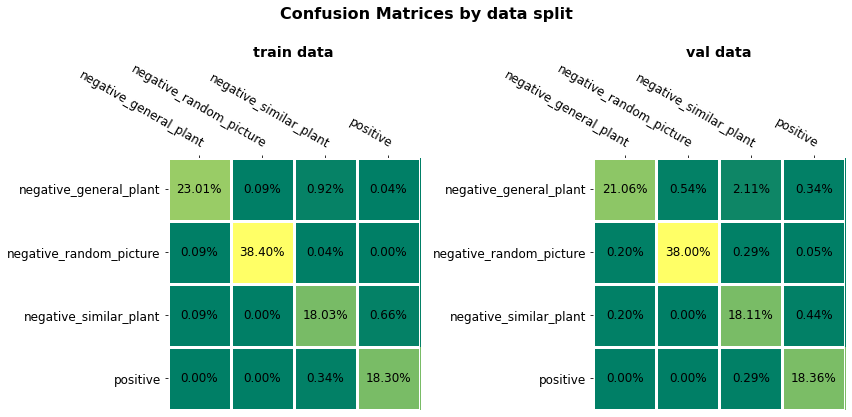

In [29]:
n_splits = df_res['split'].nunique()
fig = plt.figure(figsize=(6*n_splits,8))

for i, split in enumerate(df_res['split'].unique()):
    n_split = i+1
    ax = plt.subplot(1, n_splits, n_split)
    cm_plot = conf_mat_frac.loc[split]
    im = heatmap(cm_plot, cm_plot.index, cm_plot.columns, ax=ax, include_cbar=False, cmap="summer")
    texts = annotate_heatmap(im, valfmt="{x:.2%}")
    ax.set_title(f"{split} data", fontweight='bold')

# fig.tight_layout()
fig.tight_layout(rect=[0, 0.03, 1, 1.05])
fig.suptitle("Confusion Matrices by data split\n", fontsize=16, fontweight='bold')
# plt.subplots_adjust(top=0.8)
plt.show()

<class 'matplotlib.axes._subplots.AxesSubplot'>


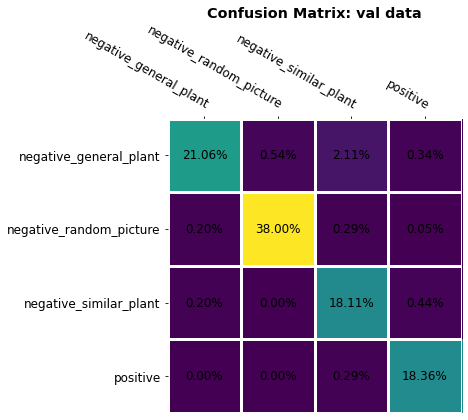

In [30]:
fig, ax = plt.subplots(figsize=(10,6))
cm_plot = conf_mat_frac.loc['val']
print(type(ax))
im = heatmap(cm_plot, cm_plot.index, cm_plot.columns, ax=ax, include_cbar=False)
texts = annotate_heatmap(im, valfmt="{x:.2%}")
ax.set_title(f"Confusion Matrix: {split} data", fontweight='bold')
fig.tight_layout()
plt.show()

In [31]:
conf_matrix_binary = (
    df_res.groupby(['split', 'binary_class', 'binary_pred'])['class_value']
        .count()
        .reset_index()
        .rename({'class_value': 'counts'}, axis=1)
        .pivot(index=['split', 'binary_class'], columns='binary_pred', values='counts')
        .fillna(0)
        .astype('int')
)
conf_matrix_binary

binary_pred         negative  positive
split binary_class                    
train negative          6570        57
      positive            28      1491
val   negative          1640        17
      positive             6       374

In [32]:
split_sums_bin = conf_matrix_binary.groupby('split').sum().sum(axis=1)
conf_mat_bin_frac = conf_matrix_binary.apply(
    lambda col: pd.DataFrame(col).apply(
        lambda row: row.iloc[0] / split_sums_bin[row.name[0]],
    axis=1), 
axis=0)
conf_mat_bin_frac

binary_pred         negative  positive
split binary_class                    
train negative      0.806531  0.006997
      positive      0.003437  0.183035
val   negative      0.805106  0.008346
      positive      0.002946  0.183603

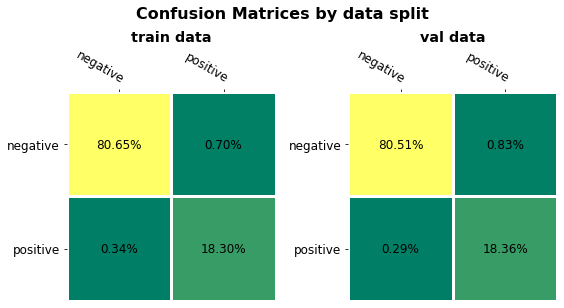

In [33]:
n_splits = df_res['split'].nunique()
fig = plt.figure(figsize=(4*n_splits,6))

for i, split in enumerate(df_res['split'].unique()):
    n_split = i+1
    ax = plt.subplot(1, n_splits, n_split)
    cm_plot = conf_mat_bin_frac.loc[split]
    im = heatmap(cm_plot, cm_plot.index, cm_plot.columns, ax=ax, include_cbar=False, cmap="summer")
    texts = annotate_heatmap(im, valfmt="{x:.2%}")
    ax.set_title(f"{split} data", fontweight='bold')

# fig.tight_layout()
fig.tight_layout(rect=[0, 0.03, 1, 1.05])
fig.suptitle("Confusion Matrices by data split\n", fontsize=16, fontweight='bold')
# plt.subplots_adjust(top=0.8)
plt.show()

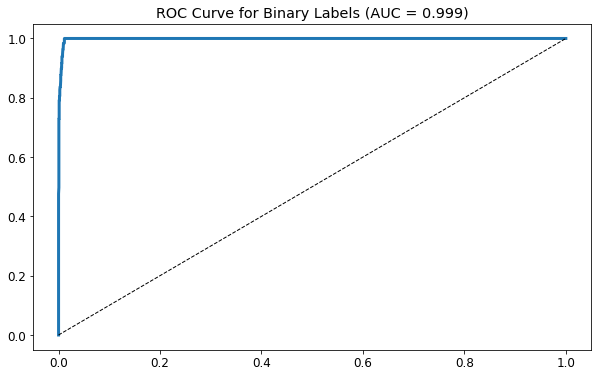

In [38]:
df_plot = df_res[df_res['split'] == 'val']
fpr, tpr, thresholds = roc_curve(df_plot['binary_class'].map({NEGATIVE: 0, POSITIVE: 1}), df_plot['positive_prob'])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10,6))
plt.title(f"ROC Curve for Binary Labels (AUC = {roc_auc:.3f})")
plt.plot(fpr, tpr, linewidth=3)
plt.plot(np.linspace(0,1), np.linspace(0,1), color='black', linestyle='--', linewidth=1)
plt.show()

## Store model

In [35]:
Path(model_output_path).parents[0].mkdir(exist_ok=True, parents=True)

In [36]:
model.save(model_output_path)

INFO:tensorflow:Assets written to: ../models/pipeline_v1/MNv3-xfer_multiclass_v1/assets


/usr/local/lib/python3.6/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [37]:
with open(model_labels_path, 'w') as f:
    json.dump({i: cn for i, cn in enumerate(class_names)}, f)